In [1]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
# !pip install implicit
# !pip install catboost


In [3]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [4]:
LOCAL_DATA_PATH = 'context_data'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [5]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [6]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

,field,type
0,region_name,string
1,city_name,string
2,cpe_manufacturer_name,string
3,cpe_model_name,string
4,url_host,string
5,cpe_type_cd,string
6,cpe_model_os_type,string
7,price,double
8,date,date32[day]
9,part_of_day,string


Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя

In [7]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

smartphone    322781599
tablet            53768
plain             36116
phablet           27952
Name: cpe_type_cd, dtype: int64

In [8]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [9]:
%%time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

CPU times: user 14.3 s, sys: 1.8 s, total: 16.1 s
Wall time: 16.1 s


In [10]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [11]:
%%time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 50, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 3.22 s, sys: 470 ms, total: 3.69 s
Wall time: 3.68 s


In [12]:
%%time
als.fit(mat)
u_factors = als.model.user_factors 
d_factors = als.model.item_factors

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 8min 29s, sys: 1.29 s, total: 8min 30s
Wall time: 26.9 s


## Получим оценку по полу

In [16]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 325 ms, sys: 63.5 ms, total: 388 ms
Wall time: 387 ms


1    135331
0    128994
Name: is_male, dtype: int64

In [15]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male'], axis=1), df['is_male'], test_size=0.33, random_state=SPLIT_SEED)

catboost_model = CatBoostClassifier()
naive_bayes_model = GaussianNB()
knn_model = KNeighborsClassifier()

estimators = [('catboost', catboost_model), ('naive_bayes', naive_bayes_model), ('knn', knn_model)]

voting_model = VotingClassifier(estimators=estimators, voting='soft', n_jobs = -1)

param_grid = {
    'catboost__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'catboost__depth': [3, 5, 7, 10, 14],
    'naive_bayes__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'knn__n_neighbors': [3, 5, 7, 10, 14],
}

grid_search = GridSearchCV(voting_model, param_grid, cv=5, n_jobs = -1)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_

print(f'GINI по полу {2 * m.roc_auc_score(y_test, best_model.predict_proba(x_test)[:, 1]) - 1:2.3f}')


GINI по полу 0.656
CPU times: user 1d 22h 37min 40s, sys: 20h 20min, total: 2d 18h 57min 41s
Wall time: 4h 21min 50s


In [17]:
best_model.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = best_model.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

In [19]:
id_to_submit['is_male'].to_csv("/home/kirrog/projects/hackatons/mtc/context_data/is_male_results.csv")

In [ ]:
best_model.save_model("/home/kirrog/projects/hackatons/mtc/context_data/is_male_catboost.bin")

In [14]:
best_clf = CatBoostClassifier()
best_clf.load_model("/home/kirrog/projects/hackatons/mtc/context_data/is_male_catboost.bin")

## Получим оценку по возрасту

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [19]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot: xlabel='age', ylabel='Count'>

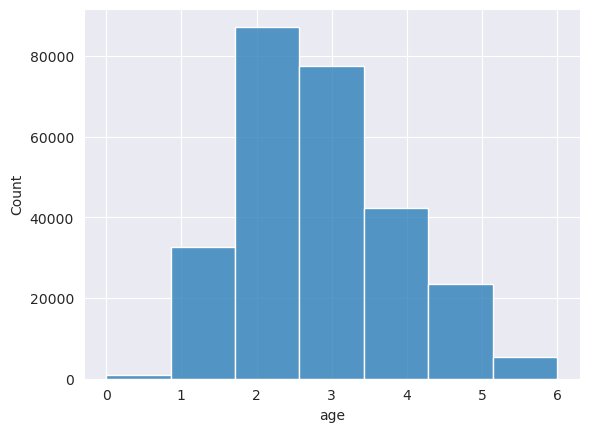

In [20]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from catboost import CatBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male'], axis=1), df['age'], test_size=0.33, random_state=SPLIT_SEED)

svm_model = SVC()
catboost_model = CatBoostClassifier()

estimators = [('svm', svm_model), ('catboost', catboost_model)]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs = -1)

param_grid = {
    'svm__C': [0.1, 1, 10, 50, 100],
    'svm__gamma': [0.1, 1, 10, 50, 100],
    'final_estimator__C': [0.1, 1, 10, 50, 100],
    'final_estimator__gamma': [0.1, 1, 10, 50, 100]
}

grid_search = GridSearchCV(stacking_model, param_grid, cv=5, n_jobs = -1)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_

print(m.classification_report('SVC', y_test, best_model.predict(x_test), target_names=['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

AttributeError: 'list' object has no attribute 'set_params'

In [ ]:
best_model.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = best_model.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

## Сабмит

In [ ]:
id_to_submit.head()

In [ ]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)

In [ ]:
! head $LOCAL_DATA_PATH/submission.csv

# Скор на лидерборде

In [ ]:
context_scorer(submission, answers)